###  This example shows how to wrap a model with Acumos Wrappers and onboard it to the Acumos Marketplace.

###  This example also shows how using Jupyter Kernel Gateway we make the Jupyter notebook function as the Model training microservice 

In [91]:
import math
import json
from collections import Counter, defaultdict, OrderedDict
import pandas as pd
from datetime import datetime

import numpy as np

import matplotlib.pyplot as plt
import re
import random
import pickle
import time
import seaborn as sns
import scipy as sp
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model as KerasModel
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras.layers import TimeDistributed, Dense
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.options.display.max_colwidth = 1000
from sklearn import manifold

import os

from IPython.display import Image

from acumos.modeling import Model as AcumosModel 
from acumos.modeling import List, Dict, create_namedtuple, create_dataframe
from acumos.session import AcumosSession

from typing import NamedTuple

acumos_user='XXXXXXXXX'
acumos_api_token='XXXXXXXXXXXXXX'
os.environ['ACUMOS_TOKEN']=acumos_user+':'+ acumos_api_token

# requiredbecause python client library functions do static type checking and expect mostly custom datatypes because python datatypes can not always serve the function..what will the rest api look like if say it accepts a dictionary?
# when code is compiled, these custom types are not available until they are actually defined. so this causes a problem when using a many functions approach. (no problem when the code does not undergo compilation and is executed step by step.)
# because there is no other way out, we create the datatype by assigning it with similar mock data.

sample = [[0.000000, 1.1111111,2.22222,3.3333,4.44444,5.555555,6.666666,7.7777777],[0.000000, 1.1111111,2.22222,3.3333,4.44444,5.555555,6.666666,7.7777777]]

np_sample = np.array(sample)

np_sample.shape

X_sample_df = pd.DataFrame(np_sample, columns=['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7'])
ClusteringDataFrame = create_dataframe('ClusteringDataFrame', X_sample_df )

ClusteringDataFrame


acumos.modeling.ClusteringDataFrame

In [93]:



# Extracts first level codes + Does one hot encoding. The number used in one-hot encoding is reason_imp.
def extract_first_level_codes(r, top_codes, reason_imp):
    vector = np.zeros(len(top_codes) + 1)
    r = r.replace(':', "+")  # : and + are separators for multiple reasons
    r = r.replace('<', '>')  # < and > are separators for reason levels
    r = r.replace('^', '>')  # number after ^ is a summary of store visit reasons, which we don't need
    single = r.split('+')  # split multiple reasons
    single = [x.split('>')[0] for x in single] #first-level reason
    index = [top_codes[k] if k in top_codes else len(top_codes) for k in single]
    vector[index] = reason_imp
    return vector


def atn_vectorize(df, top_codes, chan_imp = 1, gd_imp = 1, reason_imp = 1, billday_imp = 1, accday_imp = 1):
    '''
    input: contract sequence of atns, and feature importance
    output: dict with key: atn; value : feature vector
    '''
    atn_seq = OrderedDict() #return
    chn_codes = {'c': 0, 's': 1, 't': 2}
    
    for i, row in df.iterrows():
        cs = list(row.Contact_String)
        gap_day = str(row.gap_day).split(',')
        
        interactions = str(row.reason).lower()
        interactions = interactions.split(',')  # split multiple interactions
        for j in range(len(interactions)):
            r = interactions[j]
            interactions[j] = extract_first_level_codes(r, top_codes, reason_imp)

        for chan, gd, r in zip(cs, gap_day, interactions):
            chan_np = np.zeros(3)
            chan_np[chn_codes[chan]] = chan_imp
            if row['ATN'] not in atn_seq:
                atn_seq[row['ATN']] = []
            atn_seq[row['ATN']].append(list(chan_np) + [int(gd) * gd_imp] + list(r))
    return atn_seq


def padding(atn_seq, length):
    for k,v in atn_seq.items():
        if len(v) >= length:
            atn_seq[k] = v[-length:]
        else:
            atn_seq[k] = [[0]*len(v[0]) for i in range(length - len(v))] + v
    return atn_seq


def kmeans_cluster(df: ClusteringDataFrame) -> List[int]:
    '''Returns cluster numbers'''
    X_pred = np.column_stack(df)
    y_pred = fittedkmeans.predict(X_pred)
    return y_pred

def starttraining(modelname):

    df = pd.read_csv("./ctn-250k-sample.csv")
    df.head(2)
    
    # Not needed? Deleting ATN column and readding it to the end again. This ATN column is a replica of the CTN column.
    del df['ATN']
    df['ATN'] = df['CTN']
    df.head(2)

    dfu_pos = pd.read_csv("./cust_profile.csv")
    dfu_pre = pd.read_csv("./prepaid_profile.csv")
    dfu_pos.drop(['SALES_CHANNEL_DESCRIBE', 'CAT'], axis=1, inplace=True)
    dfu = dfu_pre.append(dfu_pos, sort=True)
    dfu = dfu.sort_values(['id'])
    dfu = dfu.apply(lambda x: x.astype(str).str.lower())
    cru_ids = set(dfu[dfu['LIAB'] == 'ent']['id'])

    df['ATN'] = df['ATN'].astype(str)
    df = df[~df['ATN'].isin(cru_ids)]

    # top_codes contains top extracted codes. Masked information.
    top_codes = {'xxx': 0,
                 'xxxxxx': 1,
                 'xxxx xxxxx': 2,
                 'xxx xxxx': 3,
                 'xxxx xxx': 4,
                 'xxxxx xxxx xxx xxxxxxxxxxx': 5,
                 'xxxxx': 6 
                 ...
                 ...
                 }

    top_codes

    Image("UsingExtractFirstLevelCodes.PNG")

    atn_seq = atn_vectorize(df, top_codes, reason_imp=100, chan_imp=800)   # WE HAVE CHOSEN THE IMPORTANCES TO BE CERTAIN VALUES. IF WE DON'T CHOOSE THEY ALL HAVE DEFAULT VALUES 1.i.e same importance. See the function definition.
    atn_seq = padding(atn_seq, 6)          # WE HAVE CHOSEN THE PADDING TO BE 6
    X = np.array(list(atn_seq.values()))  # Shape [N, T, F]
    X
    X.shape

    Image("Steps1.PNG")

    index = [i for i in range(len(X))]
    random.seed(4)
    random.shuffle(index)
    train_index = index[:len(index) * 4 // 5]
    test_index = index[len(index) * 4 // 5:]
    X_train = X[train_index, :, :]
    X_val = X[test_index, :, :]

    timesteps = 6
    input_dim = 104
    latent_dim = 8
    latent_dim_decode = 104
    inputs = Input(shape=(timesteps, input_dim))
    encoded = LSTM(latent_dim)(inputs)

    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(latent_dim_decode, return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(input_dim))(decoded)

    sequence_autoencoder = KerasModel(inputs, decoded)

     # WE HAVE BUILT THE ARCHITECTURE NOW
        
    encoder = KerasModel(inputs, encoded)             
    
    # AFTER TRAINING THE AUTOENCODER, USING FIT METHOD BELOW, ALL WE NEED IS THE ENCODER.
    
    sequence_autoencoder.compile(loss='mean_squared_error', optimizer=RMSprop())
    sequence_autoencoder.summary()

    history = sequence_autoencoder.fit(X_train, X_train, verbose=1, batch_size=32, epochs=1, validation_data=(X_val, X_val),
                                       callbacks=[EarlyStopping(patience=2)])

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower left')
    plt.show()

    X_pred = encoder.predict(X)
    X_pred.shape
    X_pd = pd.DataFrame(X_pred)

    os.getcwd()
    path1 = os.path.join(os.getcwd(), "model")
    path2 = os.path.join(os.getcwd(), "embed")

    if not os.path.exists(path1):
        os.mkdir(path1, 0o777)

    if not os.path.exists(path2):
        os.mkdir(path2, 0o777)

    X_pd.loc[:, 'ATN'] = atn_seq.keys()   # ADD ATNS AS ANOTHER ROW WHILE SAVING THE EMBEDDINGS
    cur_time = str(time.time())
    encoder.save(f"./model/encoder_model_{cur_time}.h5")
    sequence_autoencoder.save(f"./model/seq2seq_model_{cur_time}.h5")
    X_pd.to_csv(f"./embed/s2q_emb_{cur_time}.csv", index=False)

    

    n_clu = 45
    kmeans = KMeans(n_clusters=n_clu, random_state=170)
    X_pred.shape

    fittedkmeans = kmeans.fit(X_pred)
    X_pred_df = pd.DataFrame(X_pred, columns=['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7'])
    ClusteringDataFrame = create_dataframe('ClusteringDataFrame', X_pred_df)

    
    
    
    
    model = AcumosModel(classify=kmeans_cluster)

    # session = AcumosSession()
    #session.dump(model, modelname, '.')
    
    
   

    session2 = AcumosSession(push_api="<ACUMOS-IP>:<ACUMOS:PORT>/onboarding-app/v2/models")
    session2.push(model, modelname)

    return "SUCCESS"



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 6, 104)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 8)                 3616      
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 6, 8)              0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 6, 104)            47008     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 6, 104)            10920     
Total params: 61,544
Trainable params: 61,544
Non-trainable params: 0
_________________________________________________________________
Train on 275068 samples, validate on 68768 samples
Epoch 1/1
275068/275068 [==============================] - 279s 1ms/step - loss: 889.54

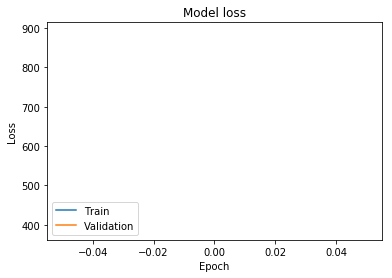

'success'

In [ ]:
# GET /train

print(json.dumps({'Training status': 'Training IN PROGRESS. This may take some time. When training has completed, Training status will show a \'success\' message'}))
req = json.loads(REQUEST)
args = req['args']

if 'modelname' not in args:
  print(json.dumps({'Training status': 'No modelname argument supplied'}))
else:
  # Note the [0] when retrieving the argument.
  # This is because you could potentially pass multiple angles.
  modelname =args['modelname'][0]
  message = starttraining(modelname)
  print(json.dumps({'Training status': message} ))
